## Introduction<a id='Introduction'></a>
Nonalcoholic steatohepatitis (NASH) affects approximately 5% of US adults and 8% of the global population. Late stages of NASH include cirrhosis of the liver, which is a major risk factor in developing cancer. Biotech companies, including Akero Therapeutics, Viking Therapeutics, Pfizer, and Novo Nordisk, have begun developing theapies for treating late stages of NASH. To be elligible for such therapies, patients must receive an MRI, which can take 2 hours per patient. With such a large patient population, pre-screening for eligiblity can expand access and can help patients in need gain access more quickly. The purpose of this project is to develop a model that predicts with over 90% accuracy the probability of a patient having late stage NASH using only readily available patient data.

The data used to train this model comes from [Kaggle](https://www.kaggle.com/datasets/fedesoriano/cirrhosis-prediction-dataset), which originates from the Mayo Clinic. Additional data from [Synthea](https://console.cloud.google.com/) could also be of interest.

## Contents<a id='Contents'></a>
* [Introduction](#Introduction)
* [Contents](#Contents)
* [Objectives](#Objectives)
* [Exploring and Cleaning the Data](#exploring_and_cleaning_the_data)
    * [Removing Columns](#Removing_Columns)
    * [Categorical Variables are Asymmetric](#categorical_variables_are_asymmetric)
    * [Removing Outliers in Numerical Variables](#removing_outliers_in_numerical_variables)
    * [Removing NaN Stages](#removing_nan_stages)
    * [Splitting According to NaN Counts](#splitting_according_to_nan_counts)
    * [Splitting According to Sex](#splitting_according_to_sex)
* [Saving Data](#saving_data)
* [Summary](#summary)    

## Objectives<a id='Objectives'></a>

* to identify the features most likely to be used in training, and understand/gain any insights into those features; 
* to clean the data so that it will be ready for processing and training

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
raw = pd.read_csv('../data/raw/cirrhosis_data.csv')

In [3]:
raw.head(3)

,ID,N_Days,Status,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage
0,1,400,D,D-penicillamine,21464,F,Y,Y,Y,Y,14.5,261.0,2.60,156.0,1718.0,137.95,172.0,190.0,12.2,4.0
1,2,4500,C,D-penicillamine,20617,F,N,Y,Y,N,1.1,302.0,4.14,54.0,7394.8,113.52,88.0,221.0,10.6,3.0
2,3,1012,D,D-penicillamine,25594,M,N,N,N,S,1.4,176.0,3.48,210.0,516.0,96.10,55.0,151.0,12.0,4.0


## Exploring and Cleaning the Data<a id='exploring_and_cleaning_the_data'></a>

### Removing Columns<a id='Removing_Columns'></a>

From the data card and the web, these columns are:
1) ID: unique identifier
2) N_Days: number of days between registration and the earlier of death, transplantation, or study analysis time in July 1986
3) Status: status of the patient C (censored), CL (censored due to liver tx), or D (death)
4) Drug: type of drug D-penicillamine or placebo

    D-penicillamine primarily can inhibit fibrogenesis and prevent the appearance of scar lesions in the liver
    
5) Age: age in [days]
6) Sex: M (male) or F (female)
7) Ascites: presence of ascites N (No) or Y (Yes)

    Ascites is pathologic accumulation of fluid in peritoneal cavity. It is the most common complication of cirrhosis and occurs in about 50% of patients with decompensated cirrhosis in 10 years. Diagnosed with ultrasound test
    
8) Hepatomegaly: presence of hepatomegaly N (No) or Y (Yes)

    Hepatomegaly is enlargement of liver beyond normal size. Diagnosed by physical exam or imaging like CT or X-ray
    
9) Spiders: presence of spiders N (No) or Y (Yes)

    Multiple spider nevi usually indicate the presence of progressive hepatic fibrosis and advanced liver disease. Identified by visual inspection
    
10) Edema: presence of edema N (no edema and no diuretic therapy for edema), S (edema present without diuretics, or edema resolved by diuretics), or Y (edema despite diuretic therapy)

    Edema is swelling of tissue by trapped fluids. Diagnosed by physical examination

11) Bilirubin: serum bilirubin in [mg/dl]

    Bilirubin is yellowing pigment made during breakdown of red blood cells. High levels can indicate liver disease. Normal range for bilirubin is 0.1-1.2

12) Cholesterol: serum cholesterol in [mg/dl]

    Sum of HDL, LDL, and triglycerides. Normal levels is < 200

13) Albumin: albumin in [gm/dl]

    Albumin is most abundant protein circulating in blood. Synthesized by liver and normal range is 3.4-5.4. 

14) Copper: urine copper in [ug/day]

    Higher than normal range may be indicative of biliary cirrhosis. Normal range 20-50

15) Alk_Phos: alkaline phosphatase in [U/liter]

    ALPs are group of isoenzymes found throughout body but in higher amounts in liver. Abnormally high levels may indicate liver disease. Normal range 44-147.

16) SGOT: SGOT in [U/ml]

    Serum glutamic-oxaloacetic transaminase also known as aspartate aminotransferase (AST) is protein made by liver cells. High levels of SGOT/AST may indicate liver damage. Normal range 8-45

17) Triglycerides: triglicerides in [mg/dl]

    Type of fat that circulate in blood. High levels may indicate fatty liver disease. Normal range < 150 for adults and < 90 for children and teenagers

18) Platelets: platelets per cubic [ml/1000]

    Cell fragments that form clots and prevent bleeding. High counts can promote fibrosis. Normal range 150-450

19) Prothrombin: prothrombin time in seconds [s]

    Prothrombin time in seconds. Prothrombin protein produced by liver to help blood clot. High prothrombin time means cirrhosis. Normal range 10-13 but can vary by lab

20) Stage: histologic stage of disease (1, 2, 3, or 4)

    F1: minimal scarring; F2: scarring has occurred and extends outside the liver area (significant fibrosis); F3: fibrosis spreading and forming bridges with other fibrotic liver areas (severe fibrosis); F4: cirrhosis or advanced scarring)

Given these descriptions, columns ```ID, N_Days, Status, Ascites``` should be removed for either being non-informative or difficult to acquire.

In [5]:
trim = raw.drop(columns=['ID', 'N_Days', 'Status', 'Ascites'])
trim = trim.rename({'Tryglicerides':'Triglycerides'}, axis=1)

### Categorical Variables are Asymmetric<a id='categorical_variables_are_asymmetric'></a>

In [6]:
cat_cols = dict(map(lambda x: (x, 'category'), ['Drug', 'Sex', 'Hepatomegaly', 'Spiders', 'Edema', 'Stage']))
trim = trim.astype(cat_cols)

In [7]:
trim.describe(include='all')

,Drug,Age,Sex,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Triglycerides,Platelets,Prothrombin,Stage
count,312,418.000000,418,312,312,418,418.000000,284.000000,418.000000,310.000000,312.000000,312.000000,282.000000,407.000000,416.000000,412.0
unique,2,NaN,2,2,2,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0
top,D-penicillamine,NaN,F,Y,N,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0
freq,158,NaN,374,160,222,354,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,155.0
mean,NaN,18533.351675,NaN,NaN,NaN,NaN,3.220813,369.510563,3.497440,97.648387,1982.655769,122.556346,124.702128,257.024570,10.731731,NaN
std,NaN,3815.845055,NaN,NaN,NaN,NaN,4.407506,231.944545,0.424972,85.613920,2140.388824,56.699525,65.148639,98.325585,1.022000,NaN
min,NaN,9598.000000,NaN,NaN,NaN,NaN,0.300000,120.000000,1.960000,4.000000,289.000000,26.350000,33.000000,62.000000,9.000000,NaN
25%,NaN,15644.500000,NaN,NaN,NaN,NaN,0.800000,249.500000,3.242500,41.250000,871.500000,80.600000,84.250000,188.500000,10.000000,NaN
50%,NaN,18628.000000,NaN,NaN,NaN,NaN,1.400000,309.500000,3.530000,73.000000,1259.000000,114.700000,108.000000,251.000000,10.600000,NaN
75%,NaN,21272.500000,NaN,NaN,NaN,NaN,3.400000,400.000000,3.770000,123.000000,1980.000000,151.900000,151.000000,318.000000,11.100000,NaN


```Sex, Spiders, Edema``` are all skewed. Given that male and female biology can significantly differ, may need to split data according to ```Sex``` anyway. As for ```Spiders```, data are not so skewed that could probably treat with over-sampling. Not sure what to do with ```Edema``` but given that majority is a lack of Edema, may be alright to leave as is. 

**Suggestion:**
1. Split data according to ```Sex``` and train a model only for women, then apply women's model to men with a caveat. There is not enough data for a men's model. 
2. Over-sample ```Spiders```.
3. Leave ```Edema``` as-is.

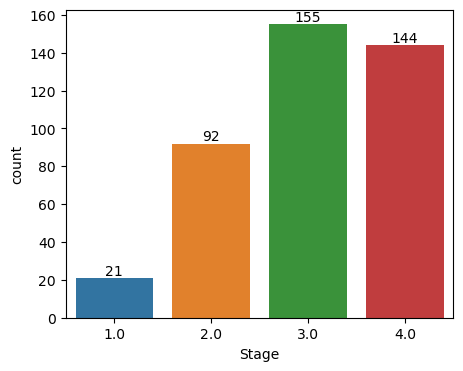

In [8]:
plt.figure(figsize=(5,4))
ax = sns.countplot(x='Stage', data=trim)
ax.bar_label(ax.containers[0]);

F1 is significantly under-sampled while F3 and F4 are nearly equally sampled. With F3 and F4 indicating severe fibrosis and cirrhosis, respectively, F3 and F4 patients are in most need of treatment. In order to balance stages, may be best to group F1 and F2 as "not-severe" and leave F3 and F4 as-is.

**Suggestion:** \
Group F1 and F2 and re-label as "not-severe"

### Removing Outliers in Numerical Variables<a id='removing_outliers_in_numerical_variables'></a>

```Age, Bilirubin, Cholesterol, Albumin, Copper, Alk_Phos, SGOT, Triglycerides, Platelets, Prothrombin```

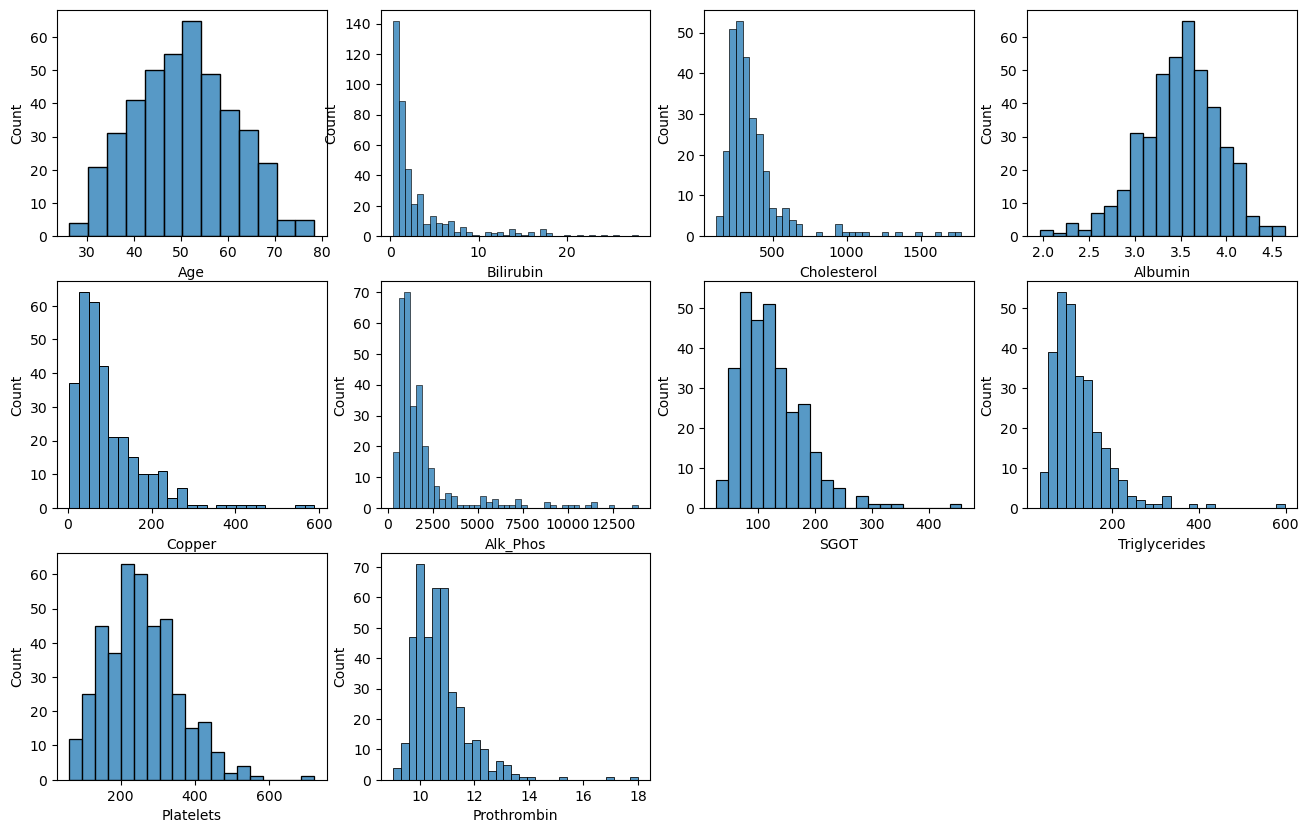

In [9]:
plt.figure(figsize=(16,10))
plt.subplot(3,4,1)
sns.histplot(x='Age', data=trim[['Age']]/365.25)
plt.subplot(3,4,2)
sns.histplot(x='Bilirubin', data=trim)
plt.subplot(3,4,3)
sns.histplot(x='Cholesterol', data=trim)
plt.subplot(3,4,4)
sns.histplot(x='Albumin', data=trim)
plt.subplot(3,4,5)
sns.histplot(x='Copper', data=trim)
plt.subplot(3,4,6)
sns.histplot(x='Alk_Phos', data=trim)
plt.subplot(3,4,7)
sns.histplot(x='SGOT', data=trim)
plt.subplot(3,4,8)
sns.histplot(x='Triglycerides', data=trim)
plt.subplot(3,4,9)
sns.histplot(x='Platelets', data=trim)
plt.subplot(3,4,10)
sns.histplot(x='Prothrombin', data=trim);

```Bilirubin, Cholesterol, Copper, Alk_phos, SGOT, Triglycerides, Platelets, Prothrombin``` all contain long tails. For ```Copper, SGOT, Triglycerides, Platelets, Prothrombin```, can likely remove outliers without affecting training data.

**Suggestion:** \
Remove rows with
* Copper > 500
* SGOT > 400
* Triglycerides > 500
* Platelets > 600
* Prothrombin > 15

In [10]:
trim[(trim['Copper']>500) | (trim['SGOT']>400) | (trim['Triglycerides']>500) | (trim['Platelets']>600) | (trim['Prothrombin']>15)]

,Drug,Age,Sex,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Triglycerides,Platelets,Prothrombin,Stage
17,D-penicillamine,19698,F,Y,Y,Y,11.4,178.0,2.80,588.0,961.0,280.55,200.0,283.0,12.4,4.0
22,Placebo,20442,F,Y,Y,Y,17.4,395.0,2.94,558.0,6064.8,227.04,191.0,214.0,11.7,4.0
74,D-penicillamine,15895,F,Y,Y,S,17.1,674.0,2.53,207.0,2078.0,182.90,598.0,268.0,11.5,4.0
106,Placebo,22836,F,N,N,N,0.6,212.0,4.03,10.0,648.0,71.30,77.0,316.0,17.1,1.0
165,Placebo,15105,F,Y,N,N,5.7,1480.0,3.26,84.0,1960.0,457.25,108.0,213.0,9.5,2.0
190,Placebo,19246,F,Y,Y,N,24.5,1092.0,3.35,233.0,3740.0,147.25,432.0,399.0,15.2,4.0
324,NaN,12419,F,NaN,NaN,N,1.8,NaN,3.24,NaN,NaN,NaN,NaN,NaN,18.0,2.0
333,NaN,20454,F,NaN,NaN,N,7.1,NaN,3.51,NaN,NaN,NaN,NaN,721.0,11.8,NaN


In [11]:
drop_ind = trim[(trim['Copper']>500) | (trim['SGOT']>400) | (trim['Triglycerides']>500) | (trim['Platelets']>600) | (trim['Prothrombin']>15)].index
trim = trim.drop(drop_ind)

### Removing NaN Stages<a id='removing_nan_stages'></a>

In [12]:
trim[trim['Stage'].isnull()]

,Drug,Age,Sex,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Triglycerides,Platelets,Prothrombin,Stage
312,NaN,21915,F,NaN,NaN,N,0.7,NaN,3.65,NaN,NaN,NaN,NaN,378.0,11.0,NaN
316,NaN,22646,F,NaN,NaN,N,0.8,NaN,2.48,NaN,NaN,NaN,NaN,273.0,10.0,NaN
318,NaN,16802,F,NaN,NaN,N,5.0,NaN,2.93,NaN,NaN,NaN,NaN,260.0,10.4,NaN
321,NaN,23376,F,NaN,NaN,N,1.1,NaN,3.69,NaN,NaN,NaN,NaN,139.0,10.5,NaN
336,NaN,20454,F,NaN,NaN,N,1.8,NaN,3.64,NaN,NaN,NaN,NaN,141.0,10.0,NaN


In [13]:
trim = trim.drop(trim[trim['Stage'].isnull()].index)

In [14]:
trim.describe(include='all')

,Drug,Age,Sex,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Triglycerides,Platelets,Prothrombin,Stage
count,306,405.000000,405,306,306,405,405.000000,278.000000,405.000000,304.000000,306.000000,306.000000,276.000000,395.000000,403.000000,405.0
unique,2,NaN,2,2,2,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0
top,D-penicillamine,NaN,F,Y,N,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0
freq,156,NaN,361,155,220,344,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,155.0
mean,NaN,18507.785185,NaN,NaN,NaN,NaN,3.089630,362.985612,3.505877,94.049342,1971.035294,120.494412,121.594203,255.706329,10.683127,NaN
std,NaN,3830.970816,NaN,NaN,NaN,NaN,4.200529,219.147083,0.421227,76.439718,2144.107466,52.596080,55.887307,96.100438,0.879401,NaN
min,NaN,9598.000000,NaN,NaN,NaN,NaN,0.300000,120.000000,1.960000,4.000000,289.000000,26.350000,33.000000,62.000000,9.000000,NaN
25%,NaN,15612.000000,NaN,NaN,NaN,NaN,0.800000,250.250000,3.260000,41.000000,862.500000,80.600000,84.000000,186.500000,10.000000,NaN
50%,NaN,18628.000000,NaN,NaN,NaN,NaN,1.300000,309.000000,3.540000,72.500000,1257.500000,113.335000,108.000000,249.000000,10.600000,NaN
75%,NaN,21247.000000,NaN,NaN,NaN,NaN,3.300000,398.250000,3.790000,122.250000,1917.000000,150.350000,149.000000,318.000000,11.100000,NaN


### Splitting According to NaN Counts<a id='splitting_according_to_nan_counts'></a>

In [15]:
nan_counts = trim.isna().sum(axis=1).rename('nan counts').astype('category').to_frame()

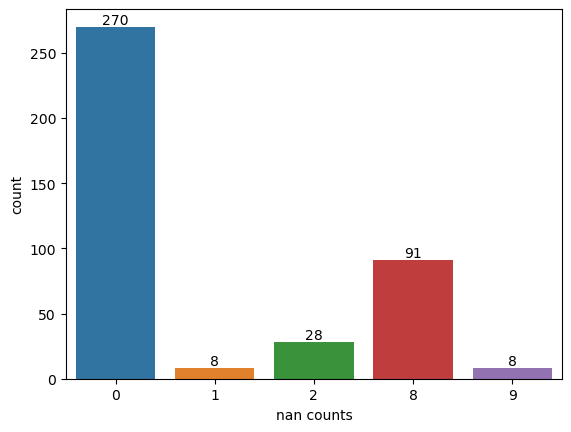

In [16]:
ax = sns.countplot(data=nan_counts, x='nan counts')
ax.bar_label(ax.containers[0]);

Now looking at a description of high nans (counts=8 or 9) vs no nans (counts=0)

In [17]:
trim[nan_counts['nan counts']==0].describe(include='all')

,Drug,Age,Sex,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Triglycerides,Platelets,Prothrombin,Stage
count,270,270.000000,270,270,270,270,270.000000,270.000000,270.000000,270.000000,270.000000,270.000000,270.000000,270.000000,270.000000,270.0
unique,2,NaN,2,2,2,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0
top,Placebo,NaN,F,Y,N,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0
freq,136,NaN,236,137,194,231,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,111.0
mean,NaN,18174.192593,NaN,NaN,NaN,NaN,3.123704,364.581481,3.524926,96.785185,1983.751852,121.817111,121.807407,261.318519,10.687407,NaN
std,NaN,3864.650267,NaN,NaN,NaN,NaN,4.266359,221.886066,0.399184,78.427803,2119.268504,52.110359,55.835326,93.627686,0.889253,NaN
min,NaN,9598.000000,NaN,NaN,NaN,NaN,0.300000,120.000000,1.960000,4.000000,289.000000,28.380000,33.000000,62.000000,9.000000,NaN
25%,NaN,15133.500000,NaN,NaN,NaN,NaN,0.800000,250.250000,3.325000,42.250000,919.500000,82.252500,85.000000,200.000000,10.000000,NaN
50%,NaN,18127.500000,NaN,NaN,NaN,NaN,1.400000,309.500000,3.550000,73.500000,1270.500000,116.250000,108.000000,256.000000,10.600000,NaN
75%,NaN,20678.500000,NaN,NaN,NaN,NaN,3.400000,399.750000,3.777500,123.000000,2043.500000,151.900000,149.000000,318.750000,11.100000,NaN


In [18]:
trim[nan_counts['nan counts']==8].describe(include='all')

,Drug,Age,Sex,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Triglycerides,Platelets,Prothrombin,Stage
count,0,91.000000,91,0,0,91,91.000000,0.0,91.000000,0.0,0.0,0.0,0.0,91.000000,91.000000,91.0
unique,0,NaN,2,0,0,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0
top,NaN,NaN,F,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0
freq,NaN,NaN,83,NaN,NaN,77,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,35.0
mean,NaN,19258.032967,NaN,NaN,NaN,NaN,3.047253,NaN,3.435824,NaN,NaN,NaN,NaN,233.120879,10.654945,NaN
std,NaN,3603.952363,NaN,NaN,NaN,NaN,4.055541,NaN,0.425770,NaN,NaN,NaN,NaN,91.803030,0.797951,NaN
min,NaN,12053.000000,NaN,NaN,NaN,NaN,0.400000,NaN,2.310000,NaN,NaN,NaN,NaN,76.000000,9.000000,NaN
25%,NaN,16071.000000,NaN,NaN,NaN,NaN,0.700000,NaN,3.145000,NaN,NaN,NaN,NaN,165.500000,10.100000,NaN
50%,NaN,19358.000000,NaN,NaN,NaN,NaN,1.400000,NaN,3.420000,NaN,NaN,NaN,NaN,225.000000,10.600000,NaN
75%,NaN,22463.000000,NaN,NaN,NaN,NaN,3.000000,NaN,3.710000,NaN,NaN,NaN,NaN,278.500000,10.950000,NaN


In [19]:
trim[nan_counts['nan counts']==9].describe(include='all')

,Drug,Age,Sex,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Triglycerides,Platelets,Prothrombin,Stage
count,0,8.000000,8,0,0,8,8.000000,0.0,8.000000,0.0,0.0,0.0,0.0,2.00000,6.000000,8.0
unique,0,NaN,1,0,0,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0
top,NaN,NaN,F,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0
freq,NaN,NaN,8,NaN,NaN,7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0
mean,NaN,19541.000000,NaN,NaN,NaN,NaN,4.350000,NaN,3.486250,NaN,NaN,NaN,NaN,403.50000,11.116667,NaN
std,NaN,3387.243085,NaN,NaN,NaN,NaN,5.144206,NaN,0.554667,NaN,NaN,NaN,NaN,21.92031,1.072225,NaN
min,NaN,16802.000000,NaN,NaN,NaN,NaN,0.700000,NaN,2.770000,NaN,NaN,NaN,NaN,388.00000,9.300000,NaN
25%,NaN,17805.750000,NaN,NaN,NaN,NaN,0.950000,NaN,2.877500,NaN,NaN,NaN,NaN,395.75000,10.750000,NaN
50%,NaN,18262.500000,NaN,NaN,NaN,NaN,2.000000,NaN,3.760000,NaN,NaN,NaN,NaN,403.50000,11.250000,NaN
75%,NaN,19906.500000,NaN,NaN,NaN,NaN,5.325000,NaN,3.930000,NaN,NaN,NaN,NaN,411.25000,11.900000,NaN


From broad description, high freq nans (counts=8 or 9) can be grouped together. Both sets are missing data for ```Heptatomegaly, Spiders, Cholesterol, Copper, Alk_Phos, SGOT, Triglycerides``` with counts=9 missing either ```Platelets``` or ```Prothrombin```.

With there being 12 predictive features and at least 7 are nans, I am worried about whether there is enough data in these records to accurately predict fibrosis staging. As for the columns with data, they have similar mean and std to the records with 0 nans.

**Suggestion:** \
Separate high frequency nans from dataset

First, recast stages as [1/2, 3, 4] from [1, 2, 3, 4]

In [21]:
trim['Stage'] = trim['Stage'].replace(to_replace={1:'1/2', 2:'1/2', 3:'3', 4:'4'})

In [22]:
low_nans = trim[~((nan_counts['nan counts']==8) | (nan_counts['nan counts']==9))]
high_nans = trim[(nan_counts['nan counts']==8) | (nan_counts['nan counts']==9)]

### Splitting According to Sex<a id='splitting_according_to_sex'></a>

In [25]:
female_lownan = low_nans[low_nans['Sex']=='F']
female_highnan = high_nans[high_nans['Sex']=='F']
male_lownan = low_nans[low_nans['Sex']=='M']
male_highnan = high_nans[high_nans['Sex']=='M']

In [28]:
female_lownan.describe(include='all')

,Drug,Age,Sex,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Triglycerides,Platelets,Prothrombin,Stage
count,270,270.000000,270,270,270,270,270.000000,243.000000,270.000000,268.000000,270.000000,270.000000,241.000000,267.000000,270.000000,270
unique,2,NaN,1,2,2,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3
top,D-penicillamine,NaN,F,N,N,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3
freq,135,NaN,270,136,188,231,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,108
mean,NaN,17954.981481,NaN,NaN,NaN,NaN,3.095556,363.061728,3.520296,85.958955,1944.113333,120.294926,119.875519,264.898876,10.640370,NaN
std,NaN,3745.974461,NaN,NaN,NaN,NaN,4.427657,224.655145,0.410511,68.903519,2108.374836,53.372738,56.302245,96.870200,0.884207,NaN
min,NaN,9598.000000,NaN,NaN,NaN,NaN,0.300000,120.000000,1.960000,4.000000,289.000000,26.350000,33.000000,62.000000,9.000000,NaN
25%,NaN,15113.000000,NaN,NaN,NaN,NaN,0.725000,252.500000,3.310000,39.750000,876.500000,80.600000,84.000000,200.000000,10.000000,NaN
50%,NaN,17847.000000,NaN,NaN,NaN,NaN,1.300000,308.000000,3.550000,67.000000,1264.000000,112.375000,106.000000,259.000000,10.600000,NaN
75%,NaN,20589.500000,NaN,NaN,NaN,NaN,3.375000,392.500000,3.770000,110.250000,1903.500000,150.262500,146.000000,324.500000,11.000000,NaN


In [30]:
male_lownan.describe(include='all')

,Drug,Age,Sex,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Triglycerides,Platelets,Prothrombin,Stage
count,36,36.000000,36,36,36,36,36.000000,35.000000,36.000000,36.000000,36.000000,36.000000,35.000000,35.000000,36.000000,36
unique,2,NaN,1,2,2,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3
top,D-penicillamine,NaN,M,Y,N,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4
freq,21,NaN,36,21,32,29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15
mean,NaN,20527.750000,NaN,NaN,NaN,NaN,2.872222,362.457143,3.579167,154.277778,2172.950000,121.990556,133.428571,235.857143,11.002778,NaN
std,NaN,4195.602558,NaN,NaN,NaN,NaN,2.234484,178.993319,0.453018,100.665389,2418.446239,47.013095,52.168441,86.969617,0.958417,NaN
min,NaN,12227.000000,NaN,NaN,NaN,NaN,0.600000,151.000000,2.270000,13.000000,516.000000,46.500000,49.000000,70.000000,9.700000,NaN
25%,NaN,17886.000000,NaN,NaN,NaN,NaN,1.375000,245.000000,3.350000,80.750000,852.000000,82.770000,91.000000,168.500000,10.300000,NaN
50%,NaN,19959.500000,NaN,NaN,NaN,NaN,2.200000,317.000000,3.700000,134.500000,1116.000000,121.675000,126.000000,217.000000,10.950000,NaN
75%,NaN,24170.500000,NaN,NaN,NaN,NaN,3.625000,426.500000,3.932500,211.750000,2313.000000,153.450000,163.000000,302.500000,11.300000,NaN


## Saving Data<a id='saving_data'></a>

In [27]:
female_lownan.to_csv('../data/interim/female_low_nans.csv')
female_highnan.to_csv('../data/interim/female_high_nans.csv')
male_lownan.to_csv('../data/interim/male_low_nans.csv')
male_highnan.to_csv('../data/interim/male_high_nans.csv')

## Summary<a id='summary'></a>

Some significant changes were made to the raw data and are listed below:
* Removed NaN stages
* Removed either non-informative or difficult-to-obtain columns
* Removed outliers
* Split according to sex
* Split according to frequency of NaNs

4 interim datasets were generated called ```female_low_nans.csv, female_high_nans.csv, male_low_nans.csv, male_high_nans.csv```

The current plan is to train a model using ```female_low_nans.csv``` and apply the model to the remaining splits. One thing to keep in mind in later notebooks is that ```Spiders``` is fairly asymmetric with the ```N``` responses dominating. It may be a good idea to balance bu over-sampling the ```Y``` responses.